In [17]:
import pandas as pd
import numpy as np
!pip install pyarrow
import pyarrow as pa
import pyarrow.parquet as pq
import os
import time
import timeit
import matplotlib.pyplot as plt
from urllib.parse import urlencode
import requests

### Step 1 | Setup Your Cloud Environment

Setup a jupyter notebook environment on a Linux-based cloud instance. You can use AWS, Cybera or any other cloud provider that you have access to. For this homework, use the following suggested configuration.

- 1 to 2 CPUs, 2 to 4 GB RAM.
- High speed block storage that is accessible to your instance. Attach a separate _block_ volume/store for this rather than using the storage of the VM. 1 GB storage should be more than enough for this homework.
- Jupyter installed, ability to install additional Python packages as needed.

In your Jupyter notebook, include code blocks that show the following information via shell or OS level commands:

- Linux distribution
- Number of CPUs
- Amount of RAM
- Mount point and amount of attached storage.

In [2]:
!lsb_release -d

No LSB modules are available.
Description:	Ubuntu 24.04 LTS


In [3]:
!nproc

2


In [4]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           3.8Gi       590Mi       3.0Gi       888Ki       492Mi       3.2Gi
Swap:             0B          0B          0B


In [6]:
!lsblk

NAME     MAJ:MIN   RM  SIZE RO TYPE MOUNTPOINTS
loop0      7:0      0 25.2M  1 loop /snap/amazon-ssm-agent/7993
loop1      7:1      0 55.7M  1 loop /snap/core18/2829
loop2      7:2      0 38.8M  1 loop /snap/snapd/21759
xvda     202:0      0    8G  0 disk 
├─xvda1  202:1      0    7G  0 part /
├─xvda14 202:14     0    4M  0 part 
├─xvda15 202:15     0  106M  0 part /boot/efi
└─xvda16 259:0      0  913M  0 part /boot
xvdbb    202:13568  0    4G  0 disk /mnt/data


### Step 2 | Download and Prepare Data

Download the following dataset to your instance from the City of Calgary's Open Data Portal.

- [Corporate Energy Consumption](https://data.calgary.ca/Environment/Corporate-Energy-Consumption/crbp-innf/about_data)

Download it in a format that will allow you to subsequently read the data into a `pandas` dataframe for in-memory processing. Also take note of the API end point of this dataset for the next step.

Convert the dataset to parquet format. Choose a partitioning strategy that is best suited for the queries in Step 3 (see below).


In your Jupyter notebook, include code cells that show:
-  The name and size of the downloaded file.
- The contents of the parent folder where the parquet file(s) are stored. Make sure that the overall size of the resulting parquet file(s) is clearly shown.

Also, discuss your partitioning strategy in a markdown cell.

In [67]:
df = pd.read_csv('CEC.csv', header=0, index_col=False, low_memory=False)

display(df.head(3))

df.dtypes

,Business Unit Desc,FacilityName,Site ID,FacilityAddress,Energy Description,Year,Month,Total Consumption,Unit
0,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Apr,1107,Kwh
1,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Aug,1130,Kwh
2,Calgary Fire Department,ATCO VILLAGE (HOUSE),0020003498361,6015 23 AV SE,Electricity,2014,Dec,1775,Kwh


Business Unit Desc    object
FacilityName          object
Site ID               object
FacilityAddress       object
Energy Description    object
Year                   int64
Month                 object
Total Consumption      int64
Unit                  object
dtype: object

In [3]:
pq_table = pa.Table.from_pandas(df)

In [4]:
pq.write_to_dataset(pq_table, 
                    root_path='part_data', 
                    partition_cols=['Year','Business Unit Desc'], 
                    compression=None)

### Partitioning Stratagy
The dataset is partitioned by `Year` and `Business Unit Desc`. This strategy is chosen as the querying in step 3 requires year period and top companies by consumption. `Year` will help us find the year periods and `Business Unit Desc` will help us compare by company.

In [5]:
!ls -alh part_data
#total size of 52K bites

total 52K
drwxrwxr-x 13 ubuntu ubuntu 4.0K Jul 11 09:51  .
drwxrwxrwx  7 root   root   4.0K Jul 11 10:58  ..
drwxrwxr-x 18 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2014'
drwxrwxr-x 19 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2015'
drwxrwxr-x 22 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2016'
drwxrwxr-x 22 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2017'
drwxrwxr-x 21 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2018'
drwxrwxr-x 19 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2019'
drwxrwxr-x 18 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2020'
drwxrwxr-x 17 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2021'
drwxrwxr-x 17 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2022'
drwxrwxr-x 17 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2023'
drwxrwxr-x 17 ubuntu ubuntu 4.0K Jul 11 09:51 'Year=2024'


In [6]:
display(pd.read_parquet('part_data/').tail())

,FacilityName,Site ID,FacilityAddress,Energy Description,Month,Total Consumption,Unit,Year,Business Unit Desc
1056466,WATER VALVE CHAMBER (CITY) - D-32835845 - AIRD...,0040001856704,"10087 TOWNSHIP RD 262, ROCKY VIEW COUNTY",Electricity,Jan,4913,Kwh,2024,Water Services
1056467,WATER VALVE CHAMBER (CITY) - D-32835845 - AIRD...,0040001856704,"10087 TOWNSHIP RD 262, ROCKY VIEW COUNTY",Electricity,Mar,4613,Kwh,2024,Water Services
1056468,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Feb,2030,Kwh,2024,Water Services
1056469,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Jan,2893,Kwh,2024,Water Services
1056470,ZOO SANITARY STATION,0020002374551,1300 ZOO RD NE,Electricity,Mar,2166,Kwh,2024,Water Services


In [7]:
file_stats = os.stat('CEC.csv')
file_size = file_stats.st_size #in bytes

print(f"Original File name: Corporate_Energy_Consumption_20240709.csv")
print(f"New File name: CEC.csv")
print(f"File size: {file_stats.st_size} Bytes")

Original File name: Corporate_Energy_Consumption_20240709.csv
New File name: CEC.csv
File size: 35605883 Bytes


### Step 3 | Comparing Query Performance

In this step, you will compare the performance of query execution for three scenarios:

1. Entire dataset in memory in the form of a `pandas` dataframe.
2. Ingesting relevant data from parquet file(s) that reside(s) on your instance via filter push down and performing any subsequent processing in memory via `pandas`.
3. Ingesting data via the SODA API end-point and executing any required filtering and aggregation operations at source via the SODA API.

Gather timing data for the following analytics tasks.

Determine the total amount of electricity used by the top 10 electricity consumers for:
- the year 2023,
- the five year period from 2019-2023, and 
- the ten year period from 2014-2023.

Produce charts that show:

- Total electricity used by the top 10 electricity consumers for the periods indicated above.
- Comparison of execution times between the three scenarios for the three periods indicated above.

Include a markdown cell that discusses your timing data and findings. Is your timing data as expected? Comment on the reasons behind the observed differences.

In [34]:
#Pandas Query

def measure_query_time(df, query):
    start_time = time.time()
    result = query(df)
    end_time = time.time()
    return result, end_time - start_time

def query_2023(df):
    return df[df['Year'] == 2023]

def query_2019_2023(df):
    return df[(df['Year'] >= 2019) & (df['Year'] <= 2023)]

def query_2014_2023(df):
    return df[(df['Year'] >= 2014) & (df['Year'] <= 2023)]

result_2023, ptime_2023 = measure_query_time(df, query_2023)
result_2019_2023, ptime_2019_2023 = measure_query_time(df, query_2019_2023)
result_2014_2023, ptime_2014_2023 = measure_query_time(df, query_2014_2023)

# Print the timing data
print(f"Query time for the year 2023: {ptime_2023:.4f} seconds")
print(f"Query time for the five-year period from 2019-2023: {ptime_2019_2023:.4f} seconds")
print(f"Query time for the ten-year period from 2014-2023: {ptime_2014_2023:.4f} seconds")

Query time for the year 2023: 0.0082 seconds
Query time for the five-year period from 2019-2023: 0.0239 seconds
Query time for the ten-year period from 2014-2023: 0.0399 seconds


In [35]:
#Parquet Query

# display(pd.read_parquet('part_data/Year=2023').head())

def measure_query_time_parquet(path, filters=None):
    start_time = time.time()
    if filters:
        result = pd.read_parquet(path, filters=filters)
    else:
        result = pd.read_parquet(path)
    end_time = time.time()
    return result, end_time - start_time

result_2023, patime_2023 = measure_query_time_parquet('part_data/Year=2023')
result_2019_2023, patime_2019_2023 = measure_query_time_parquet('part_data/', filters=[('Year','>=',2019), ('Year','<=', 2023)])
result_2014_2023, patime_2014_2023 = measure_query_time_parquet('part_data/', filters=[('Year','>=',2014), ('Year','<=', 2024)])

# # Print the timing data
print(f"Query time for the year 2023: {patime_2023:.4f} seconds")
print(f"Query time for the five-year period from 2019-2023: {patime_2019_2023:.4f} seconds")
print(f"Query time for the ten-year period from 2014-2023: {patime_2014_2023:.4f} seconds")

Query time for the year 2023: 0.0836 seconds
Query time for the five-year period from 2019-2023: 0.3936 seconds
Query time for the ten-year period from 2014-2023: 0.6829 seconds


In [19]:
#SODA API query

baseURL = 'https://data.calgary.ca/resource/crbp-innf.json'

params = '?$limit=400000'
epURL = baseURL + params

cecDF = pd.read_json(epURL)
print(cecDF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352157 entries, 0 to 352156
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   business_unit_desc  352157 non-null  object
 1   facilityname        352157 non-null  object
 2   site_id             352157 non-null  object
 3   facilityaddress     352157 non-null  object
 4   energy_description  352157 non-null  object
 5   year                352157 non-null  int64 
 6   month               352157 non-null  object
 7   total_consumption   352157 non-null  int64 
 8   unit                352157 non-null  object
dtypes: int64(2), object(7)
memory usage: 24.2+ MB
None


In [83]:
# 2023 Query
filter = '&year=2023'
# %timeit filterDF = pd.read_json(epURL + filter)
ap2023 = timeit.timeit(lambda: pd.read_json(epURL + filter), number=1)
filterDF = pd.read_json(epURL + filter)
# display(filterDF)

In [81]:
# 2019-2023 Query
filter2 = "&$where=year%20between%20'2019'%20and%20'2023'"
           
# %timeit filterDF2 = pd.read_json(epURL + filter2)
ap2019_2023 = timeit.timeit(lambda: pd.read_json(epURL + filter2), number=1)
filterDF2 = pd.read_json(epURL + filter2)
# display(filterDF2)

In [82]:
# 2014-2023 Query
filter3 = "&$where=year%20between%20'2014'%20and%20'2023'"
# %timeit filterDF3 = pd.read_json(epURL + filter3)
ap2014_2023 = timeit.timeit(lambda: pd.read_json(epURL + filter3), number=1)
filterDF3 = pd.read_json(epURL + filter3)
# display(filterDF3)

In [78]:
# ap2014_2023

6.804469628999868

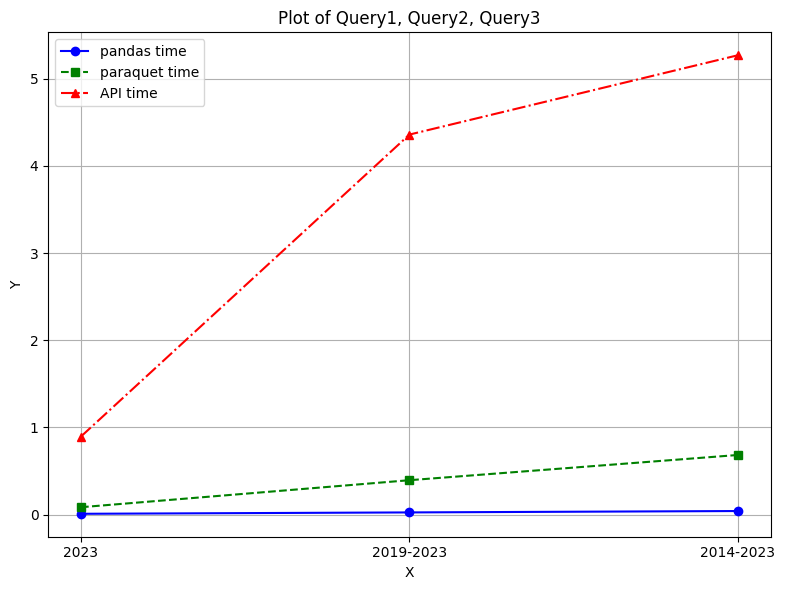

In [85]:
y1 = [ptime_2023, ptime_2019_2023, ptime_2014_2023]
y2 = [patime_2023, patime_2019_2023, patime_2014_2023]
y3 = [ap2023, ap2019_2023, ap2014_2023]

x = [1,2,3]

plt.figure(figsize=(8, 6))
plt.plot(x, y1, marker='o', linestyle='-', color='b', label='pandas time')
plt.plot(x, y2, marker='s', linestyle='--', color='g', label='paraquet time')
plt.plot(x, y3, marker='^', linestyle='-.', color='r', label='API time')

# Adding labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of Query1, Query2, Query3')
plt.xticks(x, ['2023', '2019-2023', '2014-2023'])  # Replace with meaningful labels
plt.legend()

# Display plot
plt.grid(True)
plt.tight_layout()
plt.show()



### Timing Discussion

We can clearly see that the farther we get away from local compute the slower the query time. The difference in time between the parquet and pandas query can be partially attributed to the data locality of the parquet files. To read each individual file created by the partitions creates a noticable latency. Compared to pandas which pandas which vectorizes the query all in one go in memory. Both are much faster than the SODA API query as this requires a network link, this put much more distance between the fetched files and the location of computation. 

In all cases the larger the data queried, the longer the time taken to compute.

<Figure size 1500x1000 with 0 Axes>

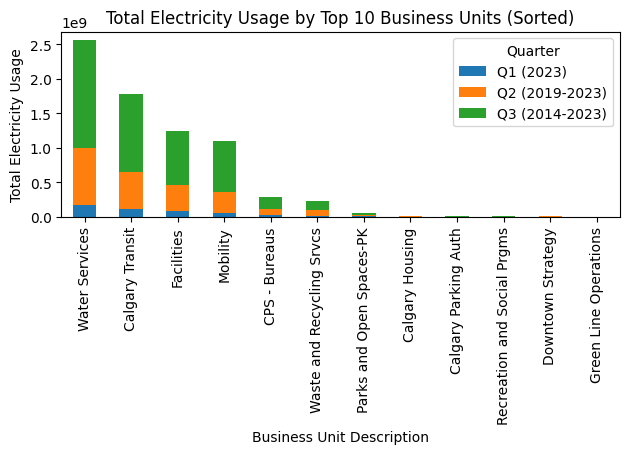

In [74]:
# Comparison Charts
Q1 = df[df['Year'] == 2023]

Q2 = df[(df['Year'] >= 2019) & (df['Year'] <= 2023)]

Q3 = df[(df['Year'] >= 2014) & (df['Year'] <= 2023)]

def top_10(df):
    grouped_df = df.groupby('Business Unit Desc')['Total Consumption'].sum()
    top_10_business_units = grouped_df.sort_values(ascending=False).head(10)
    return top_10_business_units

topQ1 = top_10(Q1)
topQ2 = top_10(Q2)
topQ3 = top_10(Q3)

combined_df = pd.DataFrame({
    'Q1 (2023)': topQ1,
    'Q2 (2019-2023)': topQ2,
    'Q3 (2014-2023)': topQ3
})

all_business_units = combined_df.index.union(topQ2.index).union(topQ3.index)

combined_df = combined_df.reindex(all_business_units).fillna(0) 

combined_df['Total'] = combined_df.sum(axis=1)
combined_df_sorted = combined_df.sort_values(by='Total', ascending=False).drop('Total', axis=1)

plt.figure(figsize=(15, 10))
combined_df_sorted.plot(kind='bar', stacked=True)

plt.xlabel('Business Unit Description')
plt.ylabel('Total Electricity Usage')
plt.title('Total Electricity Usage by Top 10 Business Units (Sorted)')
plt.legend(title='Quarter')

plt.tight_layout()
plt.show()